In [1]:
### Base ###
import os
import sys
import numpy as np 
import torch 
import torch.nn as nn
from torch.optim import Adam
import fnmatch
from torch.utils.data import TensorDataset, DataLoader
import itertools
import math
from sklearn.decomposition import PCA
import PIL.Image as pimg

### Visualization ###
#import seaborn as sns
#sns.set(color_codes=True)
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family':'serif','serif':['Palatino']})

In [2]:
### Deepshape ### 
path_to_deepshape = '/Users/alexandre.bone/Softwares/deepshape/src'
sys.path = [path_to_deepshape] + [elt for elt in sys.path if 'deformetrica' not in elt]

from support.nets_iclr import *

# 0. Functions

In [3]:
def load_eyes_black(number_of_images_train, number_of_images_test, random_seed=None):

#     path_to_train = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_black/train'
#     path_to_test = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_black/test'
    
#     path_to_train = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_black__blurred_2-5/train'
#     path_to_test = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_black__blurred_2-5/test'

#     path_to_train = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_regular/train__blurred_2-5'
#     path_to_test = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_regular/test__blurred_2-5'

    path_to_train = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_regular/train'
    path_to_test = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_regular/test'

    # Train
    intensities_train = []
    elts = sorted([_ for _ in os.listdir(path_to_train) if _[:3] == 'eye'], key=(lambda x: int(x.split('_')[-1][:-4])))
    for elt in elts:
        img = np.array(pimg.open(os.path.join(path_to_train, elt)))
        intensities_train.append(torch.from_numpy(img).float())
    intensities_train = torch.stack(intensities_train)

    assert number_of_images_train <= intensities_train.size(0), \
        'Too many required files. A maximum of %d are available' % intensities_train.size(0).shape[0]
    intensities_train = intensities_train[:number_of_images_train]

    # Test
    intensities_test = []
    elts = sorted([_ for _ in os.listdir(path_to_test) if _[:3] == 'eye'], key=(lambda x: int(x.split('_')[-1][:-4])))
    for elt in elts:
        img = np.array(pimg.open(os.path.join(path_to_test, elt)))
        intensities_test.append(torch.from_numpy(img).float())
    intensities_test = torch.stack(intensities_test)

    assert number_of_images_test <= intensities_test.size(0), \
        'Too many required files. A maximum of %d are available' % intensities_test.size(0).shape[0]
    intensities_test = intensities_test[:number_of_images_test]

    # Finalize
    intensities_template = torch.mean(intensities_train, dim=0)

    intensities_mean = float(torch.mean(intensities_train).detach().cpu().numpy())
    intensities_std = float(torch.std(intensities_train).detach().cpu().numpy())
    intensities_train = ((intensities_train - intensities_mean) / intensities_std).unsqueeze(1)
    intensities_test = ((intensities_test - intensities_mean) / intensities_std).unsqueeze(1)
    intensities_template = ((intensities_template - intensities_mean) / intensities_std).unsqueeze(0)

    return intensities_train, intensities_test, intensities_template, intensities_mean, intensities_std

class MetamorphicAtlas__JN(nn.Module):

    def __init__(self, template_intensities, number_of_time_points, downsampling_factor,
                 latent_dimension__s, latent_dimension__a,
                 kernel_width__s, kernel_width__a,
                 initial_lambda_square__s=1., initial_lambda_square__a=1.):
        nn.Module.__init__(self)

        self.decode_count = 0

        self.dimension = len(template_intensities.size()) - 1
        self.latent_dimension__s = latent_dimension__s
        self.latent_dimension__a = latent_dimension__a

        self.downsampling_factor = downsampling_factor
        self.grid_size = template_intensities.size(1)
        self.downsampled_grid_size = self.grid_size // self.downsampling_factor
        assert self.grid_size == template_intensities.size(2)
        
        self.v_star_average = torch.zeros((self.dimension, self.downsampled_grid_size, self.downsampled_grid_size))
        self.n_star_average = torch.zeros((1, self.grid_size, self.grid_size))

        self.number_of_time_points = number_of_time_points
        self.dt = 1. / float(number_of_time_points - 1)

        self.kernel_width__s = kernel_width__s
        self.kernel_width__a = kernel_width__a

        # self.template_intensities = template_intensities
        self.template_intensities = nn.Parameter(template_intensities)
        print('>> Template intensities are %d ** %d = %d parameters' % (
            template_intensities.size(1), self.dimension, template_intensities.view(-1).size(0)))

        if self.dimension == 2:
            if downsampling_factor == 1:
                self.encoder = Encoder2d__final(self.grid_size, latent_dimension__s, latent_dimension__a,
                                                init_var__s=(initial_lambda_square__s / np.sqrt(latent_dimension__s)),
                                                init_var__a=(initial_lambda_square__a / np.sqrt(latent_dimension__a)))
            else:
                self.encoder = Encoder2d__5_down(self.grid_size, latent_dimension__s, latent_dimension__a,
                                                 init_var__s=(initial_lambda_square__s / np.sqrt(latent_dimension__s)),
                                                 init_var__a=(initial_lambda_square__a / np.sqrt(latent_dimension__a)))

            self.decoder__s = DeepDecoder2d__final(latent_dimension__s, 2, self.downsampled_grid_size)
            if downsampling_factor == 1:
                self.decoder__a = DeepDecoder2d__final(latent_dimension__a, 1, self.grid_size)
            else:
                # self.decoder__a = DeepDecoder2d__5_up(latent_dimension__a, 1, self.grid_size)
                self.decoder__a = DeepDecoder2d__4_up(latent_dimension__a, 1, self.grid_size)

        elif self.dimension == 3:
            assert False
            # self.encoder = Encoder3d(self.splatting_grid_size, self.latent_dimension,
            #                          init_var=initial_lambda_square / np.sqrt(latent_dimension))
            # self.decoder = DeepDecoder3d(self.latent_dimension, self.deformation_grid_size)

        else:
            raise RuntimeError

        print('>> BayesianAtlas has {} parameters'.format(sum([len(elt.view(-1)) for elt in self.parameters()])))

    def encode(self, x):
        """
        x -> z
        """
        return self.encoder(x)

    def decode(self, s, a):
        """
        z -> y
        """

        # INIT
        bts = s.size(0)
        assert bts == a.size(0)
        ntp = self.number_of_time_points
        kws = self.kernel_width__s
        kwa = self.kernel_width__a
        dim = self.dimension
        gs = self.grid_size
        dgs = self.downsampled_grid_size
        dsf = self.downsampling_factor

        # DECODE
        # s = z[:, :self.latent_dimension__s]
        # a = z[:, -self.latent_dimension__a:]

        v_star = self.decoder__s(s) - self.v_star_average.type(str(s.type()))
        n_star = self.decoder__a(a) - self.n_star_average.type(str(a.type()))

        # GAUSSIAN SMOOTHING
        v = batched_vector_smoothing(v_star, kws, scaled=False)
        n = batched_scalar_smoothing(n_star, kwa, scaled=False)

        # NORMALIZE
        s_norm_squared = torch.sum(s ** 2, dim=1)
        a_norm_squared = torch.sum(a ** 2, dim=1)
        v_norm_squared = torch.sum(v * v_star, dim=tuple(range(1, dim + 2)))
        n_norm_squared = torch.sum(n * n_star, dim=tuple(range(1, dim + 2)))
        normalizer__s = torch.where(s_norm_squared > 1e-10,
                                    torch.sqrt(s_norm_squared / v_norm_squared),
                                    torch.from_numpy(np.array(0.0)).float().type(str(s.type())))
        normalizer__a = torch.where(a_norm_squared > 1e-10,
                                    torch.sqrt(a_norm_squared / n_norm_squared),
                                    torch.from_numpy(np.array(0.0)).float().type(str(a.type())))

        if dim == 2:
            normalizer__s = normalizer__s.view(bts, 1, 1, 1).expand(v.size())
            normalizer__a = normalizer__a.view(bts, 1, 1, 1).expand(n.size())
        elif dim == 3:
            assert False
            # normalizer = normalizer.view(bts, 1, 1, 1, 1).expand(v.size())
        v = v * normalizer__s
        n = n * normalizer__a

        if self.decode_count < 10:
            print('>> normalizer shape  = %.3E ; max(abs(v)) = %.3E' %
                  (normalizer__s.detach().cpu().numpy().reshape(-1)[0], np.max(np.abs(v.detach().cpu().numpy()))))
            print('>> normalizer appea  = %.3E ; max(abs(n)) = %.3E' %
                  (normalizer__a.detach().cpu().numpy().reshape(-1)[0], np.max(np.abs(n.detach().cpu().numpy()))))
            print('torch.max(n) = %.3f \n' % torch.max(n))
            self.decode_count += 1

        # FLOW
        grid = torch.stack(torch.meshgrid(
            [torch.linspace(0.0, gs - 1.0, dgs),
             torch.linspace(0.0, gs - 1.0, dgs)])).type(str(s.type())).view(1, 2, dgs, dgs).repeat(bts, 1, 1, 1)

        x = grid.clone() + v / float(2 ** ntp)
        for t in range(ntp):
            x += batched_vector_interpolation(x - grid, x, dsf)

        # INTERPOLATE
        intensities = batched_scalar_interpolation(self.template_intensities + n, x)
        # intensities = batched_scalar_interpolation(self.template_intensities + n * 0, x)

        return intensities

    def forward(self, s, a):
        # print('>> Please avoid this forward method.')
        return self.decode(s, a)

# 1. Load network

In [4]:
# path_to_results = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/13__new_dataset__dim_2'
#path_to_results = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/18__360__ldim_2_2__kw_10_5__no_centering__regular__blurred_2-5'
path_to_results = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/18__360__ldim_2_2__kw_10_5__no_centering__regular__centering_100'

# Load state dict 
path_to_state_dict = os.path.join(
    path_to_results, 
    sorted(fnmatch.filter(os.listdir(path_to_results), 'model__epoch_*.pth'), key=(lambda x: int(x.split('_')[-1][:-4])))[-1])
print('path_to_state_dict = %s' % os.path.basename(path_to_state_dict))
state_dict = torch.load(path_to_state_dict, map_location=lambda storage, loc: storage)

# Lead centering parameters
path_to_v_star_average = os.path.join(path_to_results, 'vsa__epoch_%s.npy' % (os.path.basename(path_to_state_dict).split('_')[-1][:-4]))
path_to_n_star_average = os.path.join(path_to_results, 'nsa__epoch_%s.npy' % (os.path.basename(path_to_state_dict).split('_')[-1][:-4]))
if os.path.isfile(path_to_v_star_average):
    print('path_to_v_star_average = %s' % os.path.basename(path_to_v_star_average))
    v_star_average = torch.from_numpy(np.load(path_to_v_star_average))
else: 
    print('v_star_average set to zero')
    dgs = state_dict.get('template_intensities').numpy().shape[-1] // 2
    v_star_average = torch.zeros((2, dgs, dgs))
if os.path.isfile(path_to_n_star_average):
    print('path_to_n_star_average = %s' % os.path.basename(path_to_n_star_average))
    n_star_average = torch.from_numpy(np.load(path_to_n_star_average))
else: 
    print('n_star_average set to zero')
    n_star_average = torch.zeros(state_dict.get('template_intensities').size())

path_to_state_dict = model__epoch_10000.pth
path_to_v_star_average = vsa__epoch_10000.npy
path_to_n_star_average = nsa__epoch_10000.npy


>> Template intensities are 64 ** 2 = 4096 parameters
>> Encoder2d__final has 19566 parameters
>> DeepDecoder2d__final has 11040 parameters
>> DeepDecoder2d__4_up has 134288 parameters
>> BayesianAtlas has 168990 parameters


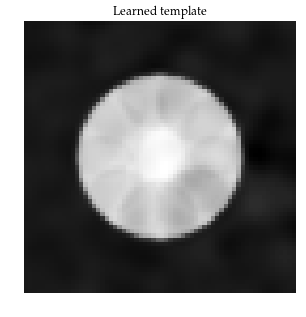

In [5]:
# GLOBALS
# output_dir = os.path.join(os.path.dirname(__file__), '../../../examples/brats', experiment_prefix)

number_of_images_train = 360
number_of_images_test = 0

downsampling_factor = 2
number_of_time_points = 5

dimension = 2
latent_dimension__s = 2
latent_dimension__a = 2

kernel_width__s = 10
kernel_width__a = 5

lambda_square__s = 1 ** 2
lambda_square__a = 0.5 ** 2
noise_variance = 0.05 ** 2

# DATA 
(intensities_train, intensities_test, intensities_template, intensities_mean, intensities_std) = load_eyes_black(
            number_of_images_train, number_of_images_test, random_seed=42)

# SET WEIGHTS
model = MetamorphicAtlas__JN(
        intensities_template, number_of_time_points, downsampling_factor,
        latent_dimension__s, latent_dimension__a,
        kernel_width__s, kernel_width__a,
        initial_lambda_square__s=lambda_square__s, initial_lambda_square__a=lambda_square__a)
model.load_state_dict(state_dict)
model.v_star_average = v_star_average
model.n_star_average = n_star_average
model.decode_count = 100

noise_dimension = model.grid_size ** model.dimension

# PRINT TEMPLATE
img = model.template_intensities.detach().cpu().numpy()[0]

figsize = 5
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Learned template')
plt.show()

# 2. Qualitative analysis

empiric_noise_std = 1.09E-01


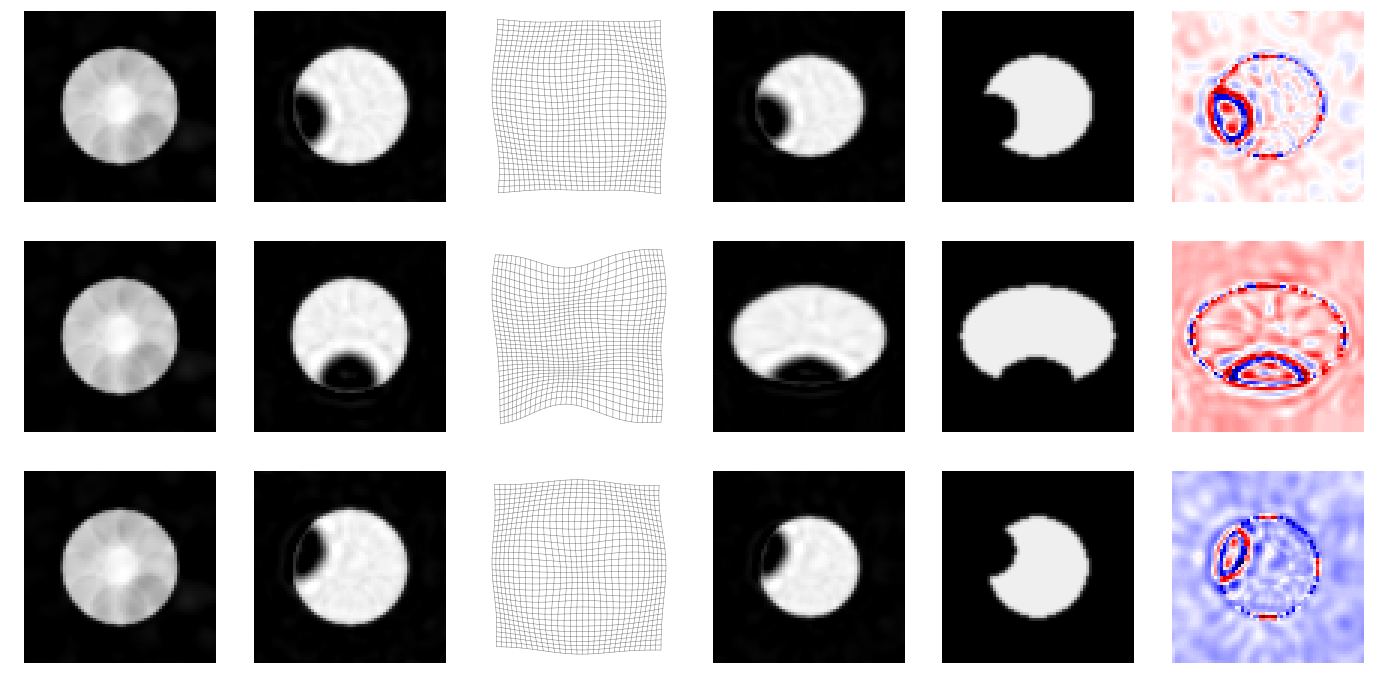

In [12]:
indexes = np.random.RandomState(seed=42).permutation(number_of_images_train)[:3]
# indexes = [0, 1, 2, 3, 4]
# indexes = np.random.permutation(number_of_images_train)[:5]

##############
### DEFORM ###
##############

mean = intensities_mean
std = intensities_std
observations = intensities_train.clone()

s, _, a, _ = model.encode(observations)

# INIT
bts = s.size(0)
assert bts == a.size(0)
ntp = model.number_of_time_points
kws = model.kernel_width__s
kwa = model.kernel_width__a
dim = model.dimension
gs = model.grid_size
dgs = model.downsampled_grid_size
dsf = model.downsampling_factor

# DECODE
# s = z[:, :model.latent_dimension__s]
# a = z[:, -model.latent_dimension__a:]

v_star = model.decoder__s(s) - model.v_star_average.type(str(s.type()))
n_star = model.decoder__a(a) - model.n_star_average.type(str(a.type()))

# GAUSSIAN SMOOTHING
v = batched_vector_smoothing(v_star, kws, scaled=False)
n = batched_scalar_smoothing(n_star, kwa, scaled=False)

# NORMALIZE
s_norm_squared = torch.sum(s ** 2, dim=1)
a_norm_squared = torch.sum(a ** 2, dim=1)
v_norm_squared = torch.sum(v * v_star, dim=tuple(range(1, dim + 2)))
n_norm_squared = torch.sum(n * n_star, dim=tuple(range(1, dim + 2)))
normalizer__s = torch.where(s_norm_squared > 1e-10,
                            torch.sqrt(s_norm_squared / v_norm_squared),
                            torch.from_numpy(np.array(0.0)).float().type(str(s.type())))
normalizer__a = torch.where(a_norm_squared > 1e-10,
                            torch.sqrt(a_norm_squared / n_norm_squared),
                            torch.from_numpy(np.array(0.0)).float().type(str(a.type())))

if dim == 2:
    normalizer__s = normalizer__s.view(bts, 1, 1, 1).expand(v.size())
    normalizer__a = normalizer__a.view(bts, 1, 1, 1).expand(n.size())
elif dim == 3:
    assert False
    # normalizer = normalizer.view(bts, 1, 1, 1, 1).expand(v.size())
v = v * normalizer__s
n = n * normalizer__a


# FLOW
grid = torch.stack(torch.meshgrid(
    [torch.linspace(0.0, gs - 1.0, dgs),
     torch.linspace(0.0, gs - 1.0, dgs)])).type(str(s.type())).view(1, 2, dgs, dgs).repeat(bts, 1, 1, 1)

x = grid.clone() + v / float(2 ** ntp)
for t in range(ntp):
    x += batched_vector_interpolation(x - grid, x, dsf)

# INTERPOLATE
intensities = batched_scalar_interpolation(model.template_intensities + n, x)

# WRITE
template = mean + std * model.template_intensities.clone()

images = []
images_ = []
for i in range(bts):
    appearance = mean + std * (model.template_intensities + n[i])
    shape = mean + std * batched_scalar_interpolation(model.template_intensities, x[i].unsqueeze(0))[0]
    metamorphosis = mean + std * intensities[i]
    target = mean + std * observations[i]

    images_i = [template, appearance, shape, metamorphosis, target]
    images_ += images_i
    images.append(images_i)
images_ = torch.cat(images_)
# vmax = torch.max(images_).detach().numpy()
vmax = torch.max(images_[indexes]).detach().numpy()

################
### RESIDUAL ###
################

empiric_noise_std = torch.sqrt(torch.sum((intensities - observations) ** 2) / float(intensities.size(0) * noise_dimension)).detach().cpu().numpy()
print('empiric_noise_std = %.2E' % empiric_noise_std)

############
### PLOT ###
############

# indexes = np.random.permutation(number_of_images_train)[:5]
# indexes = [0]

figsize = 4
nrows = len(indexes)
ncols = len(images_i) + 1
f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))
for i in range(nrows):
    for j in range(ncols):
        ax = axes.reshape(nrows, ncols)[i, j]
        index = indexes[i]

        if j == ncols-1: 
            img = (images[index][j-1] - images[index][j-2]).detach().cpu().numpy()[0] 
            ax.imshow(img, cmap='seismic')
            
        else: 
            img = images[index][j].detach().cpu().numpy()[0]
            if j != 2:
                ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)

            if j == 2:
                g = x[index].permute(1, 2, 0).detach().cpu().numpy()
                ax.plot([g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 
                        [g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()], 'grey', linewidth=0.5)
                ax.plot([g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()],
                        [g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()], 'grey', linewidth=0.5)
        
        ax.axis('off')
plt.show()

f.savefig('5_eyes_reconstructions.pdf', bbox_inches='tight')

# save_image(images_.unsqueeze(1),'5_eyes_reconstructions.pdf',
#            nrow=5, normalize=True, range=(0., float(torch.max(images_).detach().cpu().numpy())))

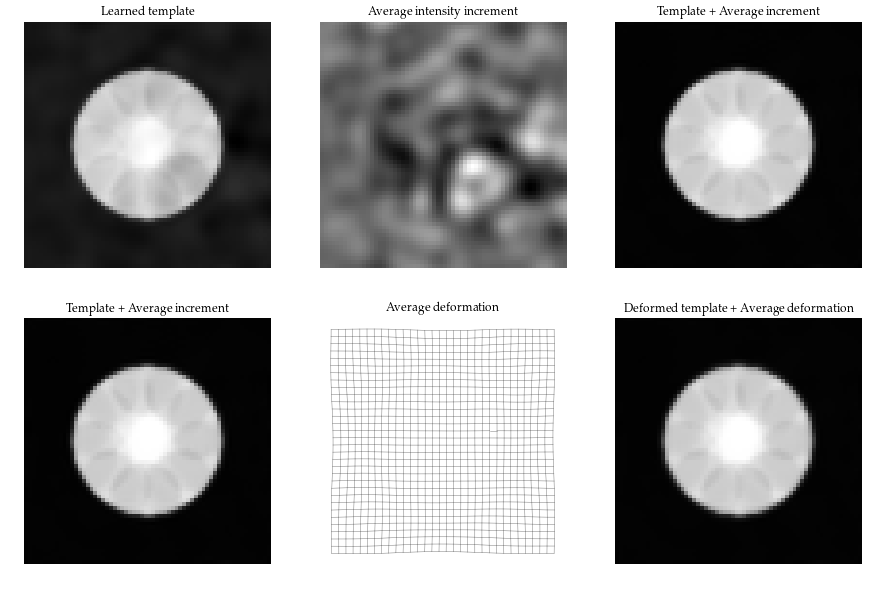

In [13]:
figsize = 5
nrows = 2
ncols = 3

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))

# Learned template
template = model.template_intensities.detach().cpu().numpy()[0]
img = template
ax = axes[0, 0]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Learned template')

# Average intensity increment
n_average = torch.mean(n, dim=0)[0].detach().cpu().numpy()
img = n_average
ax = axes[0, 1]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Average intensity increment')

# Difference
img = template + n_average
ax = axes[0, 2]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Template + Average increment')

# Learned template + increment
img = template + n_average
ax = axes[1, 0]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Template + Average increment')

# Average deformation
x_average = torch.mean(x, dim=0)
g = x_average.permute(1, 2, 0).detach().cpu().numpy()
ax = axes[1, 1]
ax.plot([g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 
        [g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()], 'grey', linewidth=0.5)
ax.plot([g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()],
        [g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()], 'grey', linewidth=0.5)
ax.axis('off')
ax.set_title('Average deformation')

# Difference
img = batched_scalar_interpolation(model.template_intensities + torch.mean(n, dim=0), 
                                   x_average.unsqueeze(0))[0].detach().cpu().numpy()[0]
ax = axes[1, 2]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Deformed template + Average deformation')

plt.show()
f.savefig('5_eyes_template.pdf', bbox_inches='tight')

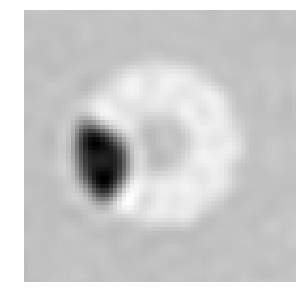

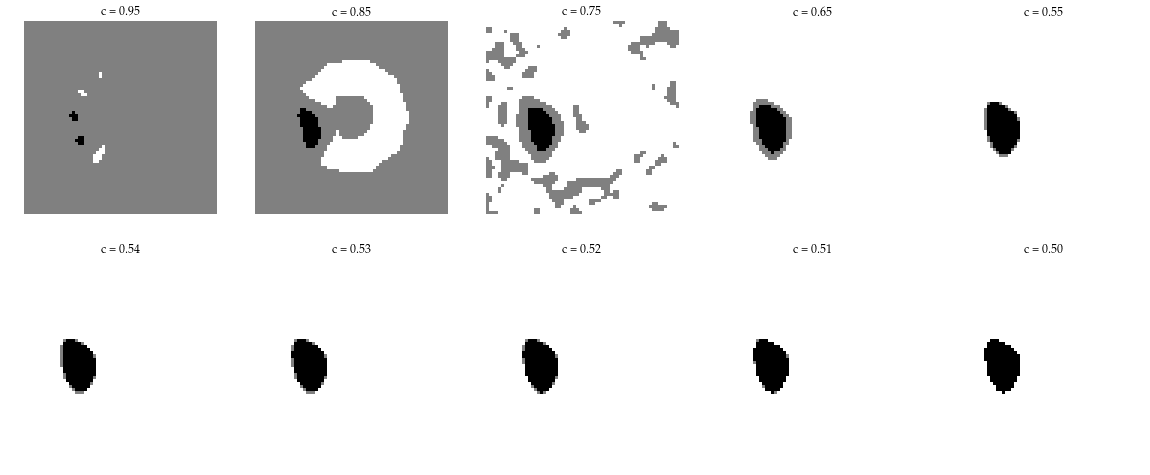

In [14]:
index = np.random.RandomState(seed=42).permutation(number_of_images_train)[0]

img = n[index, 0].detach().cpu().numpy() - n_average
img = img - np.mean(img)

figsize = 5
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(img, cmap='gray')
plt.axis('off')
# plt.title('Learned template')
plt.show()




thresholds = [0.95, 0.85, 0.75, 0.65, 0.55, 0.54, 0.53, 0.52, 0.51, 0.50]
figsize = 4
ncols = min(len(thresholds), 5)
nrows = len(thresholds) // ncols

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))
for k, c in enumerate(thresholds):
    ax = np.ravel(axes)[k]

    mi = np.min(img)
    ma = np.max(img)
    img_thres = 1.0 * (img > mi + c * (ma - mi)) - 1.0 * (img < ma - c * (ma - mi))

    ax.imshow(img_thres, cmap='gray')
    ax.axis('off')
    ax.set_title('c = %.2f' % c)

plt.show()
f.savefig('5_eyes_segmentation.pdf', bbox_inches='tight')

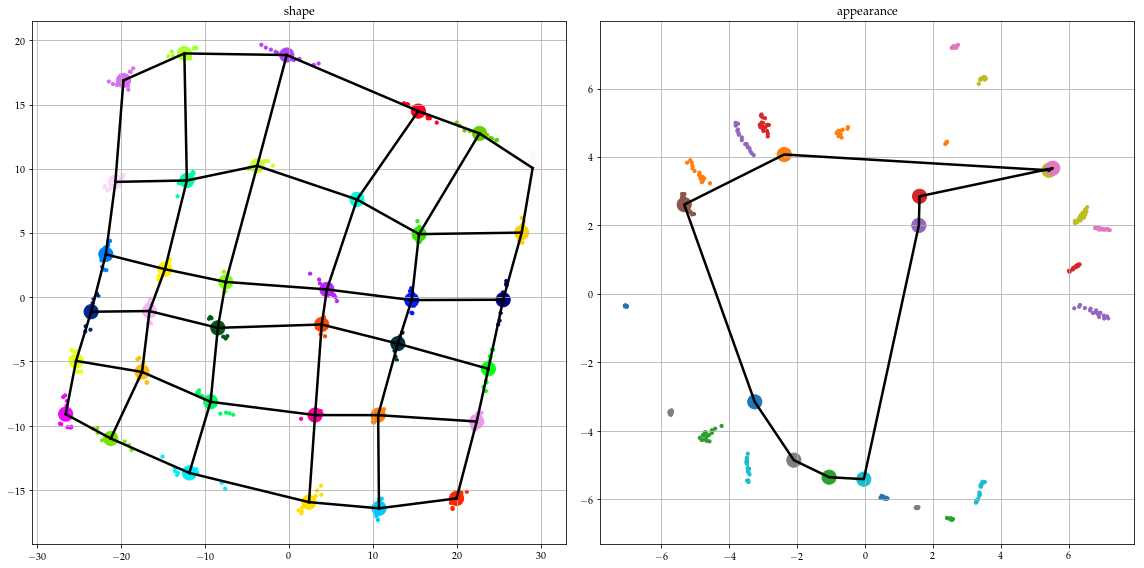

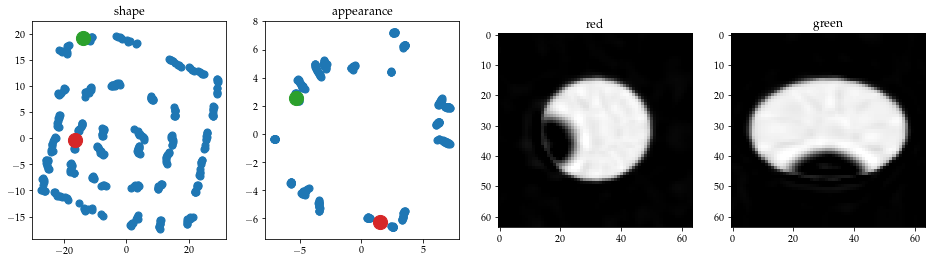

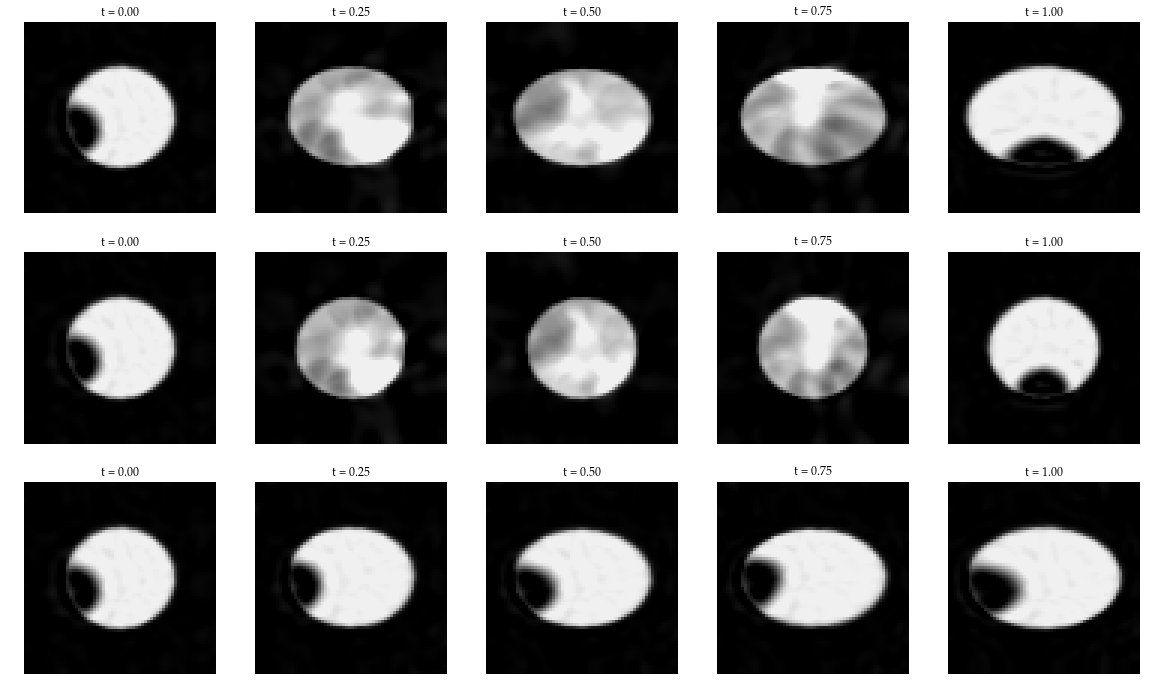

In [11]:
zs = s.detach().cpu().numpy()
za = a.detach().cpu().numpy()

figsize = 8
ncols = 2
nrows = 1
f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))

### SHAPE 
pca = PCA(2)
zs = pca.fit_transform(zs)
zsm = np.mean(zs.reshape((6 * 6, 10, 2)), axis=1)

ax = axes.ravel()[0]
cmap = cm.get_cmap('gist_ncar')
palette = np.random.RandomState(seed=42).permutation(np.arange(6 * 6))

ax.scatter(zs[:, 0], zs[:, 1], s=10, cmap=cmap, c=np.kron(palette, np.ones((10,))))
ax.scatter(zsm[:, 0], zsm[:, 1], s=200, marker='o', cmap=cmap, c=palette)

g = zsm.reshape((6, 6, 2))
ax.plot([g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 
        [g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()], 'k', linewidth=2.5)
ax.plot([g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()],
        [g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()], 'k', linewidth=2.5)


ax.grid()
ax.set_title('shape')


### APPEARANCE
pca = PCA(2)
za = pca.fit_transform(za)
zam = np.mean(za.reshape((6 * 6, 10, 2)), axis=0)

ax = axes.ravel()[1]
cmap = cm.get_cmap('tab10')
palette = np.random.RandomState(seed=42).permutation(np.arange(10))
cycle = [i % 10 for i in range(10 + 1)]

ax.scatter(za[:, 0], za[:, 1], s=10, cmap=cmap, c=np.kron(np.ones((6 * 6,)), palette))
ax.scatter(zam[:, 0], zam[:, 1], s=200, marker='o', cmap=cmap, c=palette)
ax.plot(zam[:, 0][cycle], zam[:, 1][cycle], 'k', linewidth=2.5)

ax.grid()
ax.set_title('appearance')

plt.tight_layout()
plt.show()
f.savefig('5_eyes_latent_spaces.pdf', bbox_inches='tight')


##############################
##############################
##############################

zs = s.detach().cpu().numpy()
za = a.detach().cpu().numpy()

index_a = np.random.RandomState(seed=42).permutation(number_of_images_train)[0]
index_b = np.random.RandomState(seed=42).permutation(number_of_images_train)[1]

figsize = 4
ncols = 4
nrows = 1
f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))

### SHAPE 
pca = PCA(2)
zs = pca.fit_transform(zs)

ax = axes.ravel()[0]
ax.scatter(zs[:, 0], zs[:, 1], s=50, c='tab:blue')
ax.scatter(zs[index_a, 0], zs[index_a, 1], s=200, c='tab:red')
ax.scatter(zs[index_b, 0], zs[index_b, 1], s=200, c='tab:green')
ax.set_title('shape')

### APPEARANCE
pca = PCA(2)
za = pca.fit_transform(za)

ax = axes.ravel()[1]
ax.scatter(za[:, 0], za[:, 1], s=50, c='tab:blue')
ax.scatter(za[index_a, 0], za[index_a, 1], s=200, c='tab:red')
ax.scatter(za[index_b, 0], za[index_b, 1], s=200, c='tab:green')
ax.set_title('appearance')

### Image A

ax = axes.ravel()[2]
img = images[index_a][3].detach().cpu().numpy()[0]
ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)
ax.set_title('red')

### Image B

ax = axes.ravel()[3]
img = images[index_b][3].detach().cpu().numpy()[0]
ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)
ax.set_title('green')

plt.show()


### 
### INTERPOLATION
###

s_start = s[index_a]
a_start = a[index_a]
s_end = s[index_b]
a_end = a[index_b]

T = 5
dt = 1.0 / float(T-1)

imgs = []
tol = 1e-10

# MIXED INTERPOLATION
for t in range(T): 
    at = (1.0 - t*dt) * a_start + t*dt * a_end
    st = (1.0 - t*dt) * s_start + t*dt * s_end
    
    img = torch.clamp(intensities_mean + intensities_std * model(st.unsqueeze(0), at.unsqueeze(0))[0], tol, 255. - tol)
    imgs.append(img)

# APPEARANCE INTERPOLATION
for t in range(T): 
    at = (1.0 - t*dt) * a_start + t*dt * a_end
    st = s_start
    
    img = torch.clamp(intensities_mean + intensities_std * model(st.unsqueeze(0), at.unsqueeze(0))[0], tol, 255. - tol)
    imgs.append(img)

# SHAPE INTERPOLATION
for t in range(T): 
    at = a_start
    st = (1.0 - t*dt) * s_start + t*dt * s_end
    
    img = torch.clamp(intensities_mean + intensities_std * model(st.unsqueeze(0), at.unsqueeze(0))[0], tol, 255. - tol)
    imgs.append(img)
    
imgs = torch.stack(imgs)
save_image(imgs, '5_eyes_interpolation.pdf', 
           nrow=T, normalize=True, range=(0., float(torch.max(imgs).detach().cpu().numpy())))


figsize = 4
ncols = T
nrows = len(imgs) // ncols

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))
for k, img in enumerate(imgs):
    ax = np.ravel(axes)[k]
    ax.imshow(img.detach().cpu().numpy()[0], cmap='gray', vmin=0.0, vmax=vmax)
    ax.axis('off')
    ax.set_title('t = %.2f' % ((k % 5) * dt))
plt.show()